<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://snap.stanford.edu/data/loc-gowalla.html

In [1]:
!wget https://snap.stanford.edu/data/loc-gowalla_edges.txt.gz
!gunzip loc-gowalla_edges.txt.gz

--2020-01-06 08:55:09--  https://snap.stanford.edu/data/loc-gowalla_edges.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6351523 (6.1M) [application/x-gzip]
Saving to: ‘loc-gowalla_edges.txt.gz’

loc-gowalla_edges.t 100%[===================>]   6.06M  1.21MB/s    in 5.0s    

2020-01-06 08:55:20 (1.21 MB/s) - ‘loc-gowalla_edges.txt.gz’ saved [6351523/6351523]



In [0]:
#Preprocess
import numpy as np
from collections import defaultdict

edges = []
neighbours = defaultdict(list)

with open('loc-gowalla_edges.txt', 'r') as f:
    for line in f.readlines():
        line = line[:-1]
        a,b = map(int, line.split('\t'))
        
        edges.append((a,b))
        neighbours[a].append(b)

for a in neighbours.keys():
    edges.append((a,a))

# Affinity propagation

In [0]:
# Define Similarity, Availability, Responsibility matrices

n = 196591
e = 950327*2

S = np.ones(n + e, dtype=float)   #0..e - similarity 
S[e:] = -100           #e..n+e - self-similarity

In [0]:
def update_responsibility(S, A):
    tmp = A + S

    # max_{k'!=k} (a(i,k') + s(i,k'))
    M1 = np.full(n, -np.inf)  #max tmp
    M2 = np.full(n, -np.inf)  #second max (for k==argmax)
    I = np.full(n, -1)        #argmax tmp
    for i, (a,b) in enumerate(edges):   #Diag?
        if M1[a] < tmp[i]:
            M2[a] = M1[a]
            M1[a] = tmp[i]
            I[a] = b
        elif M2[a] < tmp[i]:
            M2[a] = tmp[i]

    # R = S - max{...}
    R_new = S.copy()
    for i, (a,b) in enumerate(edges):
        if b != I[a]:
            R_new[i] -= M1[a]
        else:
            R_new[i] -= M2[a]
    
    return R_new

def update_availability(R):
    e = 950327*2
    
    tmp = R.copy()
    tmp[:e] = np.maximum(0, tmp[:e])    #... max(0, r(i',k)) for non-diag
                                            # r(k,k) are untouched
    sum_tmp = np.zeros(n) 
    for i, (a,b) in enumerate(edges):
        sum_tmp[b] += tmp[i]
    
    A_new = np.zeros_like(A)
    for i, (a,b) in enumerate(edges):
        A_new[i] = sum_tmp[b] - tmp[i]
    A_new[:e] = np.minimum(0, A_new[:e])    # min(0, ...) for non-diag

    return A_new


In [57]:
from tqdm import trange

def affinity_propagation(S, smoothing=0.5, iters=50):
    n = 196591
    e = 950327*2

    A = np.zeros_like(S)
    R = np.zeros_like(S)

    exemplars = np.array([0])

    with trange(iters) as t:
        for i in t:
            R_new = update_responsibility(S, A)        
            R = smoothing * R + (1 - smoothing) * R_new

            A_new = update_availability(R)
            A = smoothing * A + (1 - smoothing) * A_new
            
            old_exemplars = exemplars
            exemplars = np.where(A[e:] + R[e:] > 0)[0]
            t.set_postfix(exemplars=len(exemplars), inter=len(np.intersect1d(old_exemplars, exemplars)))

    exemplars = np.where(A[e:] + R[e:] > 0)[0]
    return exemplars, A+R
    
exemplars, Cr = affinity_propagation(S, iters=1000)

100%|██████████| 1000/1000 [1:56:03<00:00,  6.94s/it, exemplars=21119, inter=21097]


### Find corresponding exemplar for each node

In [0]:
def find_labels(S, exemplars, Cr):

    #Assign immediate neightbours to exemplars
    M = np.full(n, -np.inf)
    I = np.full(n, -1)
    for i, (a,b) in enumerate(edges):
        if b in exemplars and M[a] <= S[i]:
            M[a] = S[i]
            I[a] = b

    #Set identity exemplars
    for i in exemplars:
        I[i] = i
        M[i] = 1

    #For unassigned nodes, set label(i)=argmax_j(A_ij+R_ij) 
    for i, (a,b) in enumerate(edges):
        if I[a] == -1 and M[a] < Cr[i]:
            M[a] = Cr[i]
            I[a] = b

    #Transitive closure
    while True:
        new_I = I.copy()
        for i, label in enumerate(new_I):
            if label not in exemplars:
                new_I[i] = new_I[label]

        if (I == new_I).all():
            break

        I = new_I
    return new_I

In [60]:
print("Found %d exemplars" % len(exemplars))
labels = find_labels(S, exemplars, Cr)
len(np.unique(labels))

Found 21119 exemplars


21119

# Analize clusters

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


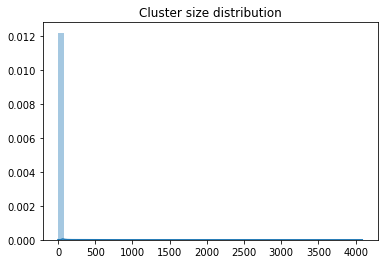

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

cluster_sizes = defaultdict(int)

for label in labels:
    cluster_sizes[label] += 1

sizes = sorted(cluster_sizes.values(), reverse=True)

plt.title("Cluster size distribution")
sns.distplot(sizes)

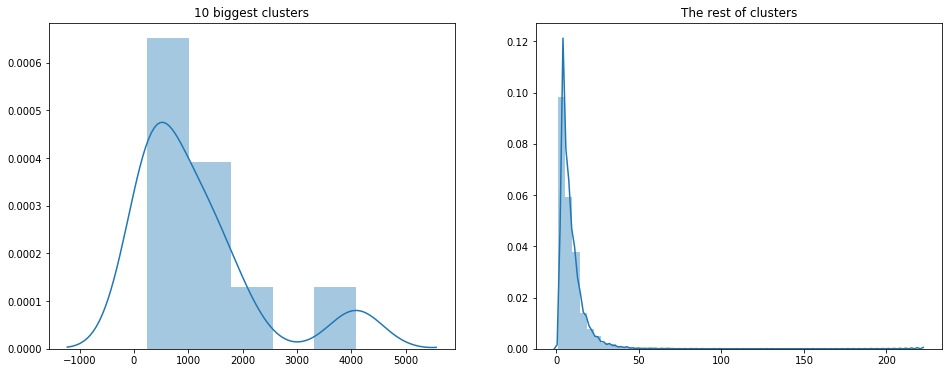

Max cluster size: 4087, min cluster size: 1


In [62]:
plt.figure(figsize=(16,6))

ax = plt.subplot(1, 2, 1)
ax.set_title("10 biggest clusters")
sns.distplot(sizes[:10])

ax = plt.subplot(1, 2, 2)
ax.set_title("The rest of clusters")
sns.distplot(sizes[10:])
plt.show()
print("Max cluster size: %d, min cluster size: %d" % (sizes[0], sizes[-1]))

# Train top-k classifier

In [63]:
!wget https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz
!gunzip loc-gowalla_totalCheckins.txt.gz

--2020-01-06 11:32:38--  https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105470044 (101M) [application/x-gzip]
Saving to: ‘loc-gowalla_totalCheckins.txt.gz’

loc-gowalla_totalCh 100%[===================>] 100.58M  20.1MB/s    in 11s     

2020-01-06 11:32:49 (9.24 MB/s) - ‘loc-gowalla_totalCheckins.txt.gz’ saved [105470044/105470044]



In [0]:
checkins = []

with open('loc-gowalla_totalCheckins.txt', 'r') as f:
    for line in f.readlines():
        line = line[:-1]
        line = line.split('\t')
        user, loc = int(line[0]), int(line[-1])
        checkins.append((user, loc))

In [0]:
checkins_by_user = defaultdict(list)

for (user, loc) in checkins:
    checkins_by_user[user].append(loc)

In [66]:
# Train test split

np.random.seed(0)

users = list(set(checkins_by_user.keys()))
users = np.array(users)
np.random.shuffle(users)

train_test_split = 0.1
split_ind = int(train_test_split*len(users))

users_train, users_test = users[split_ind:], users[:split_ind]
print("Users in train set: %d, users in test set: %d" % (len(users_train), len(users_test)))

Users in train set: 96383, users in test set: 10709


In [0]:
locations = np.array(list(set([x[1] for x in checkins])))
n_locations = len(locations)

loc_to_ind = {x:i for i,x in enumerate(locations)}

### Baseline classifier

In [68]:
k = 10

# Train
checkin_count = np.zeros_like(locations)
for user in users_train:
    for loc in checkins_by_user[user]:
        checkin_count[loc_to_ind[loc]] += 1

topk_ind = np.argpartition(checkin_count, -k)[-k:]
topk_ind = topk_ind[np.argsort(checkin_count[topk_ind])]

topk_recommended_locations = locations[topk_ind[::-1]]
print("Top-10 locations: ", topk_recommended_locations)
print("Check-ins count: ", checkin_count[topk_ind[::-1]])

Top-10 locations:  [55033 19542  9410 10259 58725 14470 10190  9246 23256  9241]
Check-ins count:  [5154 5003 4234 3775 3146 3093 3076 3045 3025 2992]


In [69]:
# Test
precision_at_k = 0

for user in users_test:
    relevant = 0
    for loc in topk_recommended_locations:
        if loc in checkins_by_user[user]:
            relevant += 1
    precision_at_k += relevant/k

precision_at_k /= len(users_test)
print("Mean precision@10 = ", precision_at_k)

Mean precision@10 =  0.01757400317489932


### Top-k classifier for each cluster

In [0]:
# Train
def train_clf(exemplars, labels, k=10):
    n_clusters = len(exemplars)
    topk_by_cluster = np.zeros((n_clusters, k))

    users_by_cluster = defaultdict(list)
    for user in users_train:
        cluster = labels[user]
        users_by_cluster[cluster].append(user)

    clust_to_ind = {x:i for i,x in enumerate(exemplars)}

    # For each cluster find top-10 locations
    for cluster, users_in_cluster in users_by_cluster.items():
        checkin_count = np.zeros_like(locations)

        for user in users_in_cluster:
            for loc in checkins_by_user[user]:
                checkin_count[loc_to_ind[loc]] += 1

        topk_ind = np.argpartition(checkin_count, -k)[-k:]
        topk_ind = topk_ind[np.argsort(checkin_count[topk_ind])]
        topk_locations = locations[topk_ind[::-1]]

        if len(topk_locations)<k:
            empty_topk = np.full(k,-1)
            empty_topk[:len(topk_locations)] = topk_locations
            topk_locations = empty_topk
        
        topk_by_cluster[clust_to_ind[cluster]] = topk_locations
    return topk_by_cluster, clust_to_ind

In [0]:
#Test
def test_clf(topk_by_cluster, clust_to_ind, k=10):
    precision_at_k = 0

    for user in users_test:
        relevant = 0

        label = labels[user]
        cluster_ind = clust_to_ind[label]

        for loc in topk_by_cluster[cluster_ind]:
            if loc in checkins_by_user[user]:
                relevant += 1
        precision_at_k += relevant/k

    precision_at_k /= len(users_test)
    return precision_at_k

In [72]:
topk_by_cluster, clust_to_ind = train_clf(exemplars, labels)
precision = test_clf(topk_by_cluster, clust_to_ind)
print("Mean precision@10 = ", precision)

Mean precision@10 =  0.050014006910076826


# The effect of the number of iterations on accuracy

In [0]:
def affinity_propagation_gen(S, smoothing=0.5, iters=50):
    n = 196591
    e = 950327*2

    A = np.zeros_like(S)
    R = np.zeros_like(S)

    for i in range(iters):
        R_new = update_responsibility(S, A)        
        R = smoothing * R + (1 - smoothing) * R_new

        A_new = update_availability(R)
        A = smoothing * A + (1 - smoothing) * A_new

        exemplars = np.where(A[e:] + R[e:] > 0)[0]
        yield exemplars, A+R


In [79]:
i = 0
for (exemplars, Cr) in affinity_propagation_gen(S, iters=20):
    i+=1

    labels = find_labels(S, exemplars, Cr)
    topk_by_cluster, clust_to_ind = train_clf(exemplars, labels)
    precision = test_clf(topk_by_cluster, clust_to_ind)

    print("[%d] %d clusters - precision@10 = %f" %(i, len(exemplars), precision))

[1] 2375 clusters - precision@10 = 0.022897
[2] 8661 clusters - precision@10 = 0.038239
[3] 16377 clusters - precision@10 = 0.048557
[4] 21414 clusters - precision@10 = 0.052871
[5] 22533 clusters - precision@10 = 0.053945
[6] 23939 clusters - precision@10 = 0.054580
[7] 24238 clusters - precision@10 = 0.054692
[8] 24563 clusters - precision@10 = 0.054356
[9] 24479 clusters - precision@10 = 0.054375
[10] 24377 clusters - precision@10 = 0.054319
[11] 24367 clusters - precision@10 = 0.054403
[12] 24220 clusters - precision@10 = 0.054281
[13] 24227 clusters - precision@10 = 0.054309
[14] 24229 clusters - precision@10 = 0.054253
[15] 24494 clusters - precision@10 = 0.054272
[16] 24541 clusters - precision@10 = 0.054412
[17] 24543 clusters - precision@10 = 0.054571
[18] 24545 clusters - precision@10 = 0.054571
[19] 24411 clusters - precision@10 = 0.054608
[20] 24412 clusters - precision@10 = 0.054562
